In [1]:
from __future__ import print_function, division

import logging

import numpy as np
import cv2
import os
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import argparse

from lib.human_depth_loader import DepthHumanDataset
from lib.network_transformer import EVANet
from config.transformer_human_config import ConfigStereoHuman as config
from lib.train_recoder import Logger, file_backup
from lib.GaussianRender import pts2render_feature
from lib.loss import l1_loss, l2_loss, ssim, psnr, opacity_regular, scale_regular, anchor_loss

import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
import torchvision
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Explore the depth component of EVA

In [2]:
class Trainer:
    def __init__(self, cfg_file):
        self.cfg = cfg_file

        self.model = EVANet(self.cfg, with_gs_render=False)
        self.train_set = DepthHumanDataset(self.cfg.dataset, phase='train')
        self.train_loader = DataLoader(self.train_set, batch_size=self.cfg.batch_size, shuffle=True,
                                       num_workers=self.cfg.batch_size*2, pin_memory=True)
        self.train_iterator = iter(self.train_loader)
        self.val_set = DepthHumanDataset(self.cfg.dataset, phase='val')
        self.val_loader = DataLoader(self.val_set, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
        self.len_val = int(len(self.val_loader) / self.val_set.val_boost)  # real length of val set
        self.val_iterator = iter(self.val_loader)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.wdecay, eps=1e-8)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, self.cfg.lr, 100100, pct_start=0.01,
                                                       cycle_momentum=False, anneal_strategy='linear')

        self.logger = Logger(self.scheduler, cfg.record)
        self.total_steps = 0

        self.model.cuda()
        if self.cfg.restore_ckpt:
            self.load_ckpt(self.cfg.restore_ckpt)
        self.model.train()
        self.scaler = GradScaler(enabled=True)

    def train(self):
        for i in tqdm(range(self.total_steps, self.cfg.num_steps)):

            self.optimizer.zero_grad()
            data = self.fetch_data(phase='train')

            #  Raft Stereo
            data, flow_loss, metrics = self.model(data)
            loss_anchor = anchor_loss(data)
            loss = flow_loss + + (10**2)*loss_anchor

            if self.total_steps and self.total_steps % self.cfg.record.loss_freq == 0:
                depth_map = data['lmain']['depth_pred']
                image = torchvision.utils.make_grid(depth_map) 
                self.logger.writer.add_image("Depth Train Left", image, global_step=self.total_steps)

                depth_map = data['lmain']['depth']
                image = torchvision.utils.make_grid(depth_map) 
                self.logger.writer.add_image("Depth Origin Left", image, global_step=self.total_steps)

                depth_map = data['rmain']['depth_pred']
                image = torchvision.utils.make_grid(depth_map) 
                self.logger.writer.add_image("Depth Train Right", image, global_step=self.total_steps)

                depth_map = data['rmain']['depth']
                image = torchvision.utils.make_grid(depth_map) 
                self.logger.writer.add_image("Depth Origin Right", image, global_step=self.total_steps)

                self.logger.writer.add_scalar(f'lr', self.optimizer.param_groups[0]['lr'], self.total_steps)
                self.save_ckpt(save_path=Path('%s/%s_latest.pth' % (cfg.record.ckpt_path, cfg.name)), show_log=False)
            metrics.update({
                'anchor': loss_anchor.item(),
            })
            self.logger.push(metrics)

            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)

            self.scaler.step(self.optimizer)
            self.scheduler.step()
            self.scaler.update()

            if self.total_steps and self.total_steps % self.cfg.record.eval_freq == 0:
                self.model.eval()
                self.run_eval()
                self.model.train()

            self.total_steps += 1

        print("FINISHED TRAINING")
        self.logger.close()
        self.save_ckpt(save_path=Path('%s/%s_final.pth' % (cfg.record.ckpt_path, cfg.name)))

    def run_eval(self):
        logging.info(f"Doing validation ...")
        torch.cuda.empty_cache()
        epe_list, one_pix_list = [], []
        show_idx = np.random.choice(list(range(self.len_val)), 1)
        for idx in range(self.len_val):
            data = self.fetch_data(phase='val')
            with torch.no_grad():
                data, flow_loss, metrics = self.model(data, is_train=False)

                for view in ['lmain', 'rmain']:
                    valid = (data[view]['depth'] != 0.0)

                    epe = torch.sum((data[view]['depth'] - data[view]['depth_pred']) ** 2, dim=1).sqrt()
                    epe = epe.view(-1)[valid.view(-1)]
                    one_per = (epe < 0.01*torch.max(data[view]['depth']))
                    
                    epe_list.append(epe.mean().item())
                    one_pix_list.append(one_per.float().mean().item())

        val_epe = np.round(np.mean(np.array(epe_list)), 4)
        val_one_per = np.round(np.mean(np.array(one_pix_list)), 4)
        logging.info(f"Validation Metrics ({self.total_steps}): epe {val_epe}, 1per {val_one_per}")
        self.logger.write_dict({'val_epe': val_epe, 'val_1per': val_one_per}, write_step=self.total_steps)
        torch.cuda.empty_cache()

    def fetch_data(self, phase):
        if phase == 'train':
            try:
                data = next(self.train_iterator)
            except:
                self.train_iterator = iter(self.train_loader)
                data = next(self.train_iterator)
        elif phase == 'val':
            try:
                data = next(self.val_iterator)
            except:
                self.val_iterator = iter(self.val_loader)
                data = next(self.val_iterator)

        for view in ['lmain', 'rmain']:
            for item in data[view].keys():
                data[view][item] = data[view][item].cuda()
        return data

    def load_ckpt(self, load_path, load_optimizer=True, strict=True):
        assert os.path.exists(load_path)
        logging.info(f"Loading checkpoint from {load_path} ...")
        ckpt = torch.load(load_path, map_location='cuda')
        self.model.load_state_dict(ckpt['network'], strict=strict)
        logging.info(f"Parameter loading done")
        if load_optimizer:
            self.total_steps = ckpt['total_steps'] + 1
            self.logger.total_steps = self.total_steps
            self.optimizer.load_state_dict(ckpt['optimizer'])
            self.scheduler.load_state_dict(ckpt['scheduler'])
            logging.info(f"Optimizer loading done")

    def save_ckpt(self, save_path, show_log=True):
        if show_log:
            logging.info(f"Save checkpoint to {save_path} ...")
        torch.save({
            'total_steps': self.total_steps,
            'network': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict()
        }, save_path)


In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

cfg = config()
cfg.load("config/pretrain.yaml")
cfg = cfg.get_cfg()

cfg.defrost()
dt = datetime.today()
cfg.exp_name = '%s_%s%s' % (cfg.name, str(dt.month).zfill(2), str(dt.day).zfill(2))

cfg.record.ckpt_path = "experiments/%s/ckpt" % cfg.exp_name
cfg.record.logs_path = "experiments/%s/logs" % cfg.exp_name
cfg.record.file_path = "experiments/%s/file" % cfg.exp_name
cfg.freeze()

In [4]:
cfg

CfgNode({'name': 'pretrain', 'stage1_ckpt': None, 'restore_ckpt': None, 'lr': 0.0002, 'wdecay': 1e-05, 'batch_size': 2, 'num_steps': 100000, 'dataset': CfgNode({'anchor': False, 'source_id': [0, 1], 'train_novel_id': None, 'val_novel_id': None, 'use_hr_img': None, 'use_processed_data': None, 'data_root': 'datasets/GPSdata', 'bg_color': [0, 0, 0], 'zfar': 100.0, 'znear': 0.01, 'trans': [0.0, 0.0, 0.0], 'scale': 1.0}), 'record': CfgNode({'ckpt_path': 'experiments/pretrain_0407/ckpt', 'show_path': None, 'logs_path': 'experiments/pretrain_0407/logs', 'file_path': 'experiments/pretrain_0407/file', 'loss_freq': 200, 'eval_freq': 5000}), 'exp_name': 'pretrain_0407'})

In [5]:
trainer = Trainer(cfg)

C:\Users\CanonUser\AppData\Local\Temp\ipykernel_12304\2592964993.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=True)


In [6]:
ckpt = torch.load("experiments/pretrain_0402/ckpt/pretrain_final.pth", map_location='cuda')
trainer.model.load_state_dict(ckpt['network'], strict=False)

C:\Users\CanonUser\AppData\Local\Temp\ipykernel_12304\4233108571.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("experiments/pretrain_0402/ckpt/pretra

<All keys matched successfully>

In [7]:
#show the depth map
data = trainer.fetch_data(phase='val')
with torch.no_grad():
    data, flow_loss, metrics = trainer.model(data, is_train=False)
depth_map = data['lmain']['depth_pred']
depth_map = depth_map.cpu().numpy()



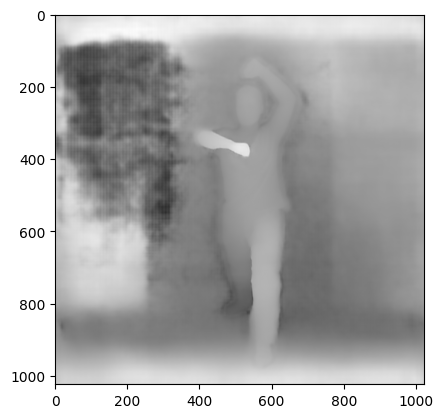

In [8]:
import matplotlib.pyplot as plt
plt.imshow(depth_map.squeeze()[1], cmap='gray')

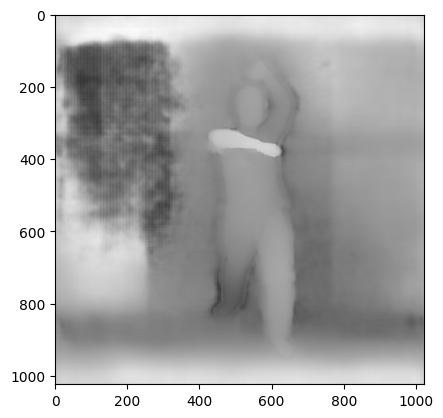

In [9]:
plt.imshow(depth_map.squeeze()[0], cmap='gray')

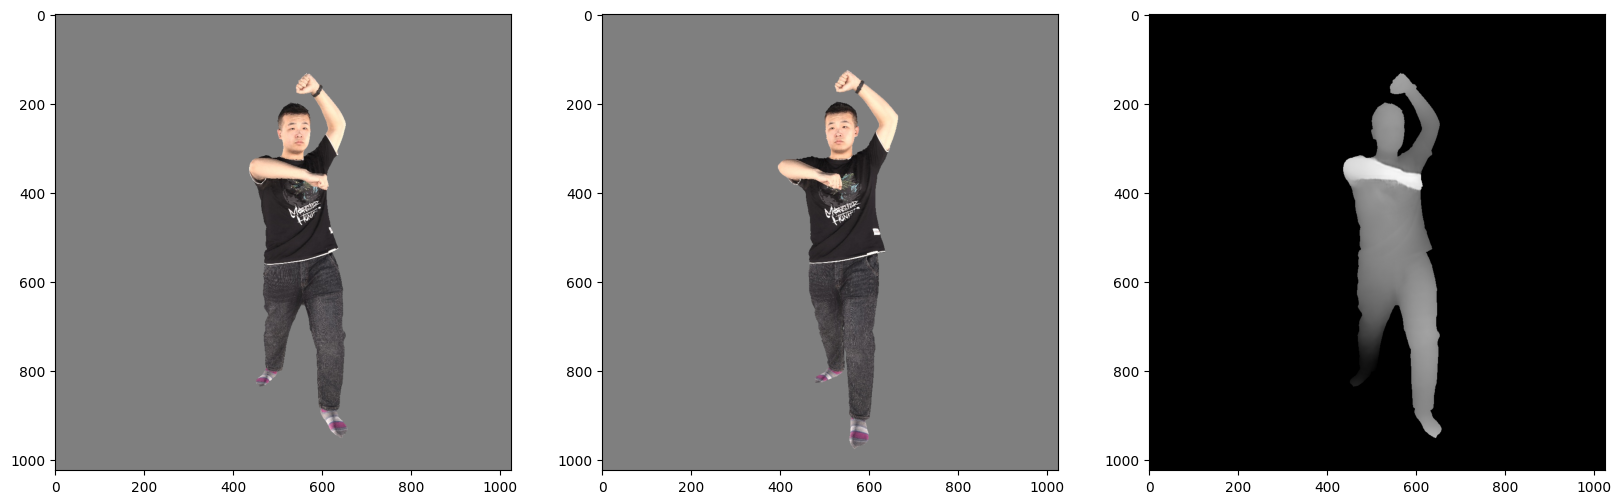

In [10]:
#show image and the depth side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
img = (data['lmain']['img'].cpu()[0].numpy().transpose(1,2,0).copy() + 1)/2
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1, 3, 2)
img = (data['rmain']['img'].cpu()[0].numpy().transpose(1,2,0).copy() + 1)/2
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1, 3, 3)
mask = data['lmain']['mask'].cpu().numpy()
depth_masked = depth_map.squeeze()[0] * mask[0][0]
val_valid = depth_masked[mask[0][0] == 1]
depth_masked = depth_masked - val_valid.min()
depth_masked = depth_masked / (val_valid.max() - val_valid.min())
depth_masked[depth_masked < 0] = 0.5
plt.imshow(mask[0][0]*depth_masked, cmap='gray')
plt.show()

# 2. EVA depth for customerized data

In [11]:
image = torch.stack([data['lmain']['img'], data['rmain']['img']], dim=0) #image seems to be from -1 to 1 without denormalization
data['lmain']['img'].shape

torch.Size([2, 3, 1024, 1024])

In [12]:
#Try loading images from custom dataset

import os
import cv2
datapath = "D:/Data/human_body_data/quentin_6cam"
img_path = os.path.join(datapath, "images")

#load up all images in the folder
img_list = os.listdir(img_path)
imgs = []
for img in img_list:
    img_full = os.path.join(img_path, img)
    img = cv2.cvtColor(cv2.imread(img_full), cv2.COLOR_BGR2RGB)

    #pad to square size
    h, w, c = img.shape

    imgs.append(img)


In [13]:
#use mediapipe to detect the foreground mask of a human body
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

BG_COLOR = (192, 192, 192) # gray
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    refine_face_landmarks=True) as holistic:
  
    image_height, image_width, _ = imgs[0].shape
    # Convert the BGR image to RGB before processing.
    results = holistic.process(imgs[0])

    img_foreground = np.uint8(imgs[0]*results.segmentation_mask[..., np.newaxis])

    #pad the image to square size
    if image_height > image_width:


SyntaxError: incomplete input (1823672182.py, line 22)

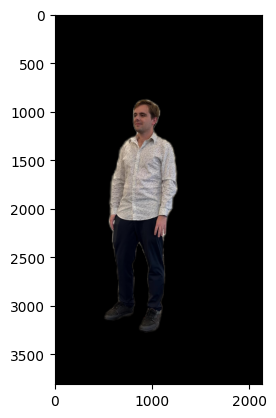

In [21]:
plt.imshow(np.uint8(imgs[0]*results.segmentation_mask[..., np.newaxis]))


In [20]:
imgs[0]

array([[[134, 122, 110],
        [134, 122, 110],
        [134, 122, 110],
        ...,
        [136, 124, 110],
        [136, 124, 110],
        [136, 124, 110]],

       [[134, 122, 110],
        [134, 122, 110],
        [134, 122, 110],
        ...,
        [136, 124, 110],
        [136, 124, 110],
        [136, 124, 110]],

       [[134, 122, 110],
        [134, 122, 110],
        [134, 122, 110],
        ...,
        [136, 124, 110],
        [136, 124, 110],
        [136, 124, 110]],

       ...,

       [[112, 103,  94],
        [102,  93,  84],
        [ 96,  87,  78],
        ...,
        [106, 102,  93],
        [102,  98,  89],
        [112, 108,  99]],

       [[107,  98,  89],
        [100,  91,  82],
        [100,  91,  82],
        ...,
        [ 89,  85,  76],
        [ 84,  80,  71],
        [ 92,  88,  79]],

       [[ 96,  87,  78],
        [ 92,  83,  74],
        [ 96,  87,  78],
        ...,
        [ 76,  72,  63],
        [ 77,  73,  64],
        [ 79,  75,  66]]

2025-04-07 15:03:42,403 WARNING  [image.py:661] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


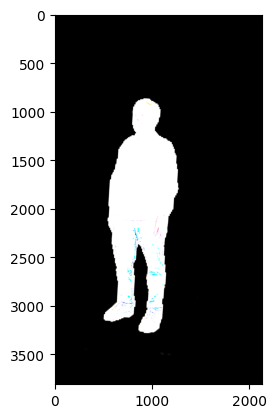

In [46]:
plt.imshow((np.float32(imgs[0])*results.segmentation_mask[..., np.newaxis]))